<a href="https://colab.research.google.com/github/msibriani/information_retrieval_eq2/blob/main/Avance4_Equipo2_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

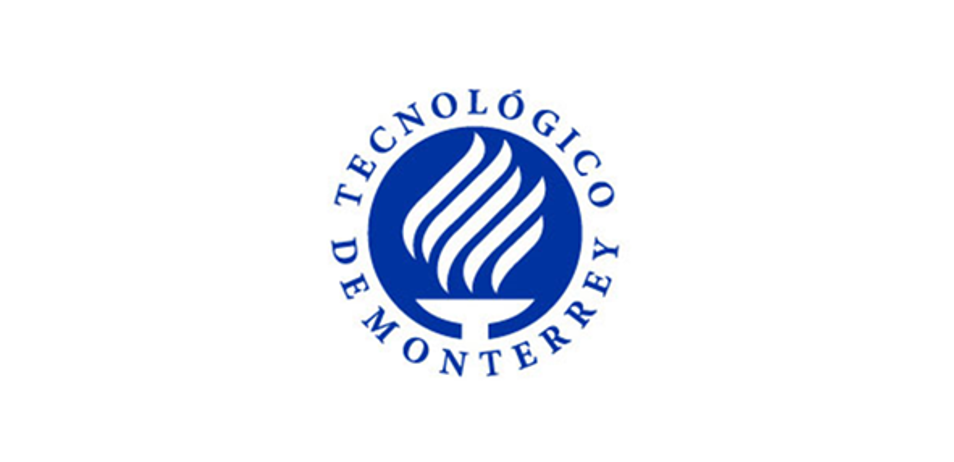

# MNA Maestría en Inteligencia Artificial Aplicada
# MNA Maestría en Inteligencia Artificial Aplicada

###Materia: TC5035.10 Proyecto Integrador
 (Gpo 10)



###Prof. Titulares:
###Dra. Grettel Barceló Alonso
###Dr. Luis Eduardo Falcón Morales



###Avance 4. Otros Modelos.



###EQUIPO 2
###Alumnos - Matrícula
###**Matthias Sibrian Illescas - A01794249**
###**José Ramiro Adán Charles - A00174646**
###**Genaro Ramos Higuera - A00351269**

###Instalamos librerias de trabajo

In [1]:
!pip install haystack-ai
!pip install "sentence-transformers>=2.2.0"
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.5/319.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)

Cargamos librerias y definimos los metodos para cargar en memoria los documentos y la conversion de los PDFs

In [6]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["application/pdf"])
pdf_converter = PyPDFToDocument()


Definimos el metodo para limpiar los documentos

In [7]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=200, split_overlap=50)


Agregamos el embedder que utilizaremos en el Pipeline para los documentos que escribiremos en la document store.

In [8]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)


Ahora armamos la secuencia del Pipeline a aplicar a los documentos PDF

In [9]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")


Ahora conectamos el Pipeline:

In [10]:
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("pypdf_converter", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")


🚅 Components
  - file_type_router: FileTypeRouter
  - pypdf_converter: PyPDFToDocument
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pypdf_converter.sources (List[Path])
  - pypdf_converter.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])

###Cargamos todos los documentos de la carpeta de PDFs /content/data/pdf
###y aplicamos el Pipeline de preprocesamiento

In [12]:
from pathlib import Path

carpeta_pdfs = "/content/data/pdf"
preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(carpeta_pdfs).glob("**/*"))}})


Batches:   0%|          | 0/149 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 4756}}

Ahora utilizaremos el mismo embedder para las preguntas (questions) y poder hacer la recuperacion mediante el Retriever.

In [13]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")


In [14]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store)


Ahora definimos el prompt builder para las preguntas y le decimos que tome el contexto de los documentos para generar las respuestas

In [15]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)


Ahora cargamos el API Key para el LLM que utilizaremos:

In [16]:
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")


Enter OpenAI API key:··········


In [17]:
generator = OpenAIGenerator(model="gpt-3.5-turbo")

In [18]:
basic_rag_pipeline = Pipeline()
# Adicionamos los componentes al pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Ahora los conectamos dentro del pipeline
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

## Ahora haremos las siguientes preguntas al LLM y que se base en el contexcto de documentos

1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?
2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?
3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?
4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?
5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?
6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?
7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?
8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?
9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?
10. ¿Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?
11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?
12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?
13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?
14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?

In [19]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La definición exacta de un crédito académico en nuestra institución es la siguiente:

- Preparatoria: 3 créditos académicos son equivalentes a 6 unidades académicas.
- Profesional: 3 créditos académicos son equivalentes a 8 unidades académicas.
- Posgrado: 3 créditos académicos son equivalentes a 12 unidades académicas.


In [20]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina considerando que un crédito académico representa un total de 120 horas de trabajo, incluyendo horas de clase y horas de trabajo independiente. Por lo tanto, se establece que un crédito académico equivale a 40 horas de trabajo independiente del estudiante.


In [21]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas nacionales e internacionales establecidas por el Tecnológico de Monterrey, específicamente en los lineamientos y requisitos para realizar convenios de cooperación académica internacional, publicados en el Reglamento para la Gestión y Operación de Programas Internacionales. Además, los convenios de cooperación académica internacional son administrados, revisados y autorizados por la Dirección de Internacionalización, siguiendo las normativas establecidas.


In [22]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas nacionales e internacionales relacionadas con convenios de cooperación académica internacional, programas internacionales del Tecnológico de Monterrey, así como lineamientos y requisitos establecidos por la Dirección de Internacionalización y publicados en el Reglamento para la Gestión y Operación de Programas Internacionales.


In [23]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas mediante la definición de políticas y procedimientos que se aplican en todas las unidades de formación de preparatoria, profesional y posgrado en la institución. Además, se establece que la determinación de los créditos académicos en cada unidad de formación se hace de forma que el total de créditos académicos de un semestre de un plan de estudios de los programas sea similar a los de un semestre de los planes de estudio de profesional, maestría y doctorado.


In [24]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula en base al tiempo de trabajo que el alumno dedica a la unidad de formación para cumplir con los objetivos del mismo. Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno. En el caso de programas de salud con actividades clínicas, la carga académica se mide por el tiempo total que la unidad de formación demande a los alumnos durante una semana. Cada unidad de formación se asigna un determinado número de créditos académicos de acuerdo a esta carga de trabajo.


In [25]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula al asignar créditos, ya que los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno.


In [26]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través de la definición de un crédito académico, que incluye 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual son 54 horas en total durante el periodo académico. Además, se menciona que cada unidad de formación tiene asignados 2 créditos, y se establece la carga académica de tiempo completo por periodo regular y periodo intensivo. También se señala que la determinación de los créditos académicos en cada unidad de formación se hace de forma que el total de créditos académicos en las unidades de formación sea similar a los de un semestre de los planes de estudio de profesional, maestría y doctorado.


In [27]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional mediante la traducción de la escala de calificaciones a su equivalente con el Sistema Tecnológico de Monterrey en todos los convenios con universidades extranjeras. Además, la asignación de calificaciones se hará de acuerdo con criterios establecidos y los alumnos serán informados sobre los criterios de calificación y carga académica antes de su participación en cualquier convenio.


In [28]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones en el Tecnológico de Monterrey implica varios pasos. Primero, el alumno debe presentar oficialmente su solicitud de transferencia de créditos a la institución. Luego, el Departamento de Registro Académico del Tecnológico de Monterrey revisará el contenido de los cursos cursados en la institución de origen para determinar si son equivalentes a los cursos ofrecidos en el Tecnológico de Monterrey.

Para asegurar la equivalencia de los créditos transferidos, se compararán los cursos cursados en la institución de origen con los cursos ofrecidos en el Tecnológico de Monterrey en términos de contenido, carga académica, y requisitos de curso. Si se determina que los cursos son equivalentes, se otorgarán los créditos correspondientes en el Tecnológico de Monterrey.

Es importante destacar que la decisión final sobre la transferencia de créditos recae en el Departamento de Registro Académico y que se seguirán los lineamientos y 

In [29]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos son utilizados para medir el tiempo y esfuerzo que los estudiantes dedican a cada materia o unidad de formación. Estos créditos son asignados a cada unidad de formación de acuerdo con la carga académica que se debe cumplir en un semestre, ya sea en programas de preparatoria, profesional o posgrado. Los créditos académicos permiten a los estudiantes tener una guía sobre la carga de trabajo que conlleva cada materia, así como planificar de manera efectiva su progreso académico, ya que les ayuda a determinar cuántos créditos deben cursar en cada periodo y cuántos deben completar en total para obtener su título. Además, los créditos académicos son utilizados para la homologación y comparación de la carga académica entre diferentes niveles educativos y programas de estudio. Por lo tanto, los créditos académicos son una herramienta fundamental para que los estudiantes puedan organizar su plan de estudios y avanzar de manera estructurada hacia la culminación de su carr

In [30]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan en diferentes ocasiones, como se menciona en el contexto, se realizan cambios en los reglamentos académicos a partir de la fecha indicada y se incluyen en las Políticas y Normas Académicas Generales en la próxima edición. También se menciona que se actualiza la definición de crédito académico en programas de posgrado. Por lo tanto, las políticas de créditos académicos se revisan y actualizan periódicamente.


In [31]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios de dedicación por crédito, como el número de horas de sesiones con el profesor y horas de trabajo independiente del estudiante, para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso.


In [32]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según la información proporcionada, la distribución de horas en el cálculo de un crédito académico es la siguiente: 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual da un total de 54 horas durante el periodo académico.


## Ahora probamos con el LLM Mistral mistralai/Mixtral-8x7B-Instruct-v0.1

In [34]:
from haystack.components.generators import HuggingFaceAPIGenerator

if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token:")

Enter Hugging Face token:··········


In [35]:

generator =HuggingFaceAPIGenerator(api_type="serverless_inference_api", api_params={"model": "mistralai/Mixtral-8x7B-Instruct-v0.1"})

In [36]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Para Preparatoria, un crédito académico equivale a 2 unidades académicas. Para Profesional, un crédito académico equivale a 2.67 unidades académicas. Para Posgrado, un crédito académico equivale a 4 unidades académicas.


In [37]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina considerando que un crédito académico representa 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual equivale a un total de 54 horas durante el periodo académico.


In [38]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas nacionales e internacionales establecidas por el Tecnológico de Monterrey, específicamente en los lineamientos y requisitos para realizar convenios de cooperación académica internacional, establecidos por la Dirección de Internacionalización y publicados en el Reglamento para la Gestión y Operación de Programas Internacionales.


In [39]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se están siguiendo normativas internacionales relacionadas con convenios de cooperación académica internacional establecidos por el Tecnológico de Monterrey con instituciones educativas de otros países, así como lineamientos para la gestión y operación de programas internacionales aplicables según el nivel de estudios, establecidos por la Dirección de Internacionalización.


In [40]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas se aseguran mediante la definición de políticas y procedimientos que se aplican en todas las unidades de formación de preparatoria, profesional y posgrado ofrecidas en la institución. Estas políticas son responsabilidad de las Escuelas y de los departamentos académicos, y se establecen normativas que deben ser seguidas para la determinación de los créditos académicos en cada unidad de formación. Además, se define que el total de créditos académicos que integran un semestre de un plan de estudios debe ser similar en los diferentes programas de posgrado, profesional, maestría y doctorado.


In [41]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula representando el tiempo de trabajo que un alumno dedica a la unidad de formación para cumplir con los objetivos del curso. Los créditos académicos también representan la asistencia a las horas-clase y el tiempo dedicado al trabajo independiente del alumno. En el caso de programas de salud con actividades clínicas, la carga académica se mide por el tiempo total que la unidad de formación demande a los alumnos durante una semana.


In [42]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera el tiempo dedicado al trabajo independiente del alumno, como tareas y proyectos, al asignar créditos académicos en el contexto descrito.


In [43]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información se comunica de la siguiente manera:
- Cada unidad de formación se asigna un determinado número de créditos académicos.
- La determinación de los créditos académicos se hace de forma que el total de créditos de un semestre sea similar en todos los programas.
- Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno.
- Se establece cuántas horas de sesiones con el profesor y de trabajo independiente se requieren por cada crédito.
- Se menciona que las microcredenciales deben tener una duración mínima equivalente a la suma de las horas de clase y trabajo independiente de un crédito académico.


In [44]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de los créditos académicos con otras instituciones a nivel nacional e internacional mediante la traducción de la escala de calificaciones de las universidades extranjeras a su equivalente en el Sistema Tecnológico de Monterrey y estableciendo criterios de calificación y carga académica antes de la participación en convenios de programa internacional. Además, se verifica la calidad y oficialidad de los grados académicos, así como la equivalencia del grado con el sistema educativo mexicano consultando registros oficiales y agencias acreditadoras.


In [45]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones generalmente implica proporcionar los documentos requeridos, como transcripciones académicas y descripciones de los cursos previamente completados. Estos documentos se envían al departamento de admisiones o registro de la nueva institución, que evaluará la equivalencia de los créditos y determinará qué cursos pueden ser transferidos hacia el programa de estudio actual. Para asegurar la equivalencia, la nueva institución comparará los contenidos y los requisitos de los cursos previamente completados con los cursos en su propio plan de estudios, garantizando que los créditos transferidos cumplan con los estándares y requisitos académicos del programa en el que se inscribirá el estudiante.


In [46]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos son una medida de la carga de trabajo que los estudiantes deben completar en una unidad de formación. Influyen en el progreso y la planificación académica de los estudiantes al determinar cuántas unidades de formación deben cursar para completar un semestre, programa de estudios o nivel educativo específico. Además, los créditos académicos les permiten a los estudiantes tener una guía sobre cuánto tiempo y esfuerzo dedicar a cada materia, facilitando la organización de su tiempo y la gestión de sus responsabilidades académicas. Los créditos académicos también son importantes para la transferencia de créditos entre programas educativos y la homologación de estudios en diferentes instituciones.


In [47]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan con periodicidad, como se menciona en el contexto, se incluirán en las Políticas y Normas Académicas Generales en su próxima edición. No se especifica una frecuencia exacta, pero se da a entender que se actualizan de forma regular.


In [48]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios como el número de horas de sesiones con el profesor, horas de trabajo independiente del estudiante, y la dedicación total de cada crédito durante el periodo académico.


In [49]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La distribución de horas en el cálculo de un crédito académico es de 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico.


## Ahora probamos con el LLM Cohere "CohereForAI/aya-23-8B"

In [50]:
generator =HuggingFaceAPIGenerator(api_type="serverless_inference_api", api_params={"model": "CohereForAI/aya-23-8B"})

In [51]:
question = "1. ¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La definición exacta de un crédito académico en nuestra institución para los 3 niveles es la siguiente:
- En Preparatoria: 3 créditos académicos equivalen a 6 unidades académicas.
- En Profesional: 3 créditos académicos equivalen a 8 unidades académicas.
- En Posgrado: 3 créditos académicos equivalen a 12 unidades académicas.


In [52]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina mediante la suma de horas clase y horas de trabajo independiente asignadas a ese crédito. Por ejemplo, en el contexto proporcionado, un crédito académico equivale a 40 horas, que se distribuyen entre horas clase y horas de trabajo independiente para cumplir con los objetivos de aprendizaje de la materia o unidad de formación.


In [53]:
question = "3. ¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas nacionales e internacionales establecidas en el Reglamento para la Gestión y Operación de Programas Internacionales, aplicable de acuerdo al nivel de estudios, publicado por la Dirección de Internacionalización para la asignación de créditos académicos. También se menciona que se están implementando cambios en la unidad de medida de carga académica, evolucionando de "Unidades" a "Créditos Académicos" siguiendo lineamientos internos de la institución.


In [54]:
uestion = "4. ¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo normativas internacionales establecidas por la Organización de Naciones Unidas para la asignación de créditos académicos.


In [55]:
question = "5. ¿Cómo se aseguran los estándares de calidad y coherencia en la asignación de créditos a través de diferentes departamentos y programas?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los estándares de calidad y coherencia en la asignación de créditos se aseguran a través de la definición de políticas y procedimientos que regulan la carga académica de cada unidad de formación, el tiempo de trabajo dedicado por los estudiantes y la asignación de créditos académicos en cada unidad. Estas políticas se aplican en todas las unidades de formación de preparatoria, profesional y posgrado, en todos los formatos y campus de la institución. Además, se establecen criterios específicos para la asignación de créditos en cada tipo de programa, ya sean especialidades, maestrías o doctorados, asegurando que el total de créditos académicos en un semestre sea coherente con los planes de estudio de cada nivel. Asimismo, se cuenta con un proceso de autorización de las Credenciales Alternativas que confieren créditos en posgrado, el cual debe ser aprobado por instancias específicas dentro de la institución.


In [56]:
question = "6. ¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula considerando el tiempo total que la unidad de formación demande a los alumnos durante una semana. A cada unidad de formación se asignará un determinado número de créditos académicos, los cuales representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno.


In [57]:
question = "7. ¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula al asignar créditos, ya que los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno.


In [58]:
question = "8. ¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada se comunica a los estudiantes a través de la definición del crédito académico en posgrado, la cual establece que cada crédito académico equivale a 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, totalizando 54 horas en total durante el periodo académico. Además, se menciona que cada unidad de formación tiene asignados 2 créditos, y se detalla la carga académica de tiempo completo por periodo regular y por periodo intensivo. También se indica que las unidades de formación se imparten a razón de tres horas-clase por semana, tanto en periodos semestrales como intensivos, lo que permite a los estudiantes conocer la dedicación total requerida para cada asignatura.


In [59]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional se garantiza mediante la inclusión de la traducción de la escala de calificaciones a su equivalente con el Sistema Tecnológico de Monterrey en todos los convenios con universidades extranjeras. Además, se establecen criterios de calificación y carga académica del programa antes de la partida de los alumnos, y se asegura que los grados académicos sean oficiales y estén registrados en los ministerios o secretarías de educación de cada país, verificando también la equivalencia del grado con el sistema educativo mexicano.


In [60]:
question = "10. Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones generalmente implica que el estudiante presente su historial académico y los programas de estudio de las unidades de formación a las que haya sido sometido en la otra institución. Luego, se revisa si los créditos obtenidos son equivalentes a los ofrecidos en la institución receptora. Para asegurar la equivalencia de los créditos, se comparan los programas de estudio, la carga horaria de las asignaturas, los contenidos temáticos y los objetivos de aprendizaje. Además, se pueden llevar a cabo exámenes de nivelación para determinar si el estudiante cuenta con el conocimiento necesario para acreditar la materia en cuestión. Una vez completada esta revisión, se determina la cantidad de créditos que pueden ser transferidos y se incorporan al expediente académico del estudiante en la nueva institución.


In [61]:
question = "11. ¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos influyen en el progreso y la planificación académica de los estudiantes al determinar la carga de trabajo que deben cumplir en cada unidad de formación, así como en el total de créditos necesarios para completar un semestre o un plan de estudios completo. Los créditos académicos también facilitan la comparación y homologación de programas educativos, asegurando que exista equivalencia en la carga académica entre diferentes niveles de estudios, como preparatoria, profesional, maestría y doctorado. Esto permite a los estudiantes tener una guía clara sobre la cantidad de trabajo que deben realizar para avanzar en sus estudios de manera efectiva.


In [62]:
question = "12. ¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan con frecuencia, considerando que los cambios aplican a partir de la fecha especificada y se incluirán en las Políticas y Normas Académicas Generales en la próxima edición.


In [63]:
question = "13. ¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios como el número de créditos académicos reprobados y el promedio establecido como requisito para la conservación de la beca en el programa.


In [64]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según la información proporcionada, en el cálculo de un crédito académico se consideran 15 horas de sesiones con el profesor y 39 horas de trabajo independiente del estudiante, lo cual da un total de 54 horas de dedicación para cumplir con el crédito académico.
